In [1]:
from processing.utils import *
from processing.utils2 import *
from processing.utils3 import *
from processing.gpcrdb_soup import *
from processing.download import *
from processing.processor import *
from processing.df_to_cif import *
from processing.bondtypes import *
from analysis.analysis import *


from torch_geometric.data import Data
import numpy as np
import torch
from scipy.spatial.distance import cdist, pdist
from tqdm import trange

In [ ]:
# Filtering etc is done with the processor!

In [2]:
p = CifProcessor()

In [3]:
p.read_pkl_metainfo()

In [4]:
p.read_pkl(mode='rg', folder='data/processed/')

  0%|                                                                                                                                                                                                             | 0/545 [00:00<?, ?it/s]

Reading files with generic numbers on receptors and gproteins.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 545/545 [03:04<00:00,  2.95it/s]


In [5]:
BOND_TYPE_DF

,H,N,C,O,S
H,0,1,2,3,4
N,1,5,6,7,8
C,2,6,9,10,11
O,3,7,10,12,13
S,4,8,11,13,14


In [6]:
FULL_ATOM_LIST = list(p.dfl[0]['label_atom_id'].unique())

In [7]:
class GraphProcessor:
    def __init__(self,
                 d: list,
                 p: CifProcessor):
        self.d = d
        self.p = p
        self.allow_exception=False
        
        self.simplified = False
        if 'generic_position' in list(p.dfl[0].columns):
            self.simplified=True
        
        self.atom_list = FULL_ATOM_LIST
        self.edge_criteria = ['self', 'distance']
        self.edge_features = ['unitary', 'distance', 'EM']
        self.node_criteria = ['H5']
    
    # ================================================================================================================
    
    def simplify(self):
        if not self.simplified:
            for i in trange(len(self.p.dfl)):
                if self.allow_exception:
                    try:
                        df = self.p.dfl[i]
                        self.p.dfl[i] = pd.DataFrame()
                        self.p.dfl[i] = self._simplify_gen_pos(df).reset_index()
                    except:
                        pass
                else:
                    df = self.p.dfl[i]
                    self.p.dfl[i] = pd.DataFrame()
                    self.p.dfl[i] = self._simplify_gen_pos(df).reset_index()
                self.simplified = True
        else:
            pass
        
    def _simplify_gen_pos(self, df):
        def sgp(gen_pos='', gprot_pos=''):
            if gprot_pos != '':
                return gprot_pos
            else:
                return gen_pos.split('x')[0]
        cols = list(df.columns)
        if ('gen_pos' in cols) and ('gprot_pos' in cols):
            df['generic_position'] = df.apply(lambda x: sgp(x.gen_pos, x.gprot_pos), axis=1)
            df.drop(['group_PDB', 'label_seq_id', 'label_asym_id',
                    'auth_seq_id', 'id',
                    'phi', 'omega', 'psi', 'label_comp_id',
                    'label_2_uni', 'gen_pos', 'gen_pos1', 'gen_pos2', 'gprot_pos',
                    'uniprot_comp_id', 'fam_comp_id', 'uniprot_comp_sid'], axis=1, inplace=True)
            return df
        elif 'gen_pos' in cols:
            df['generic_position'] = df.apply(lambda x: sgp(x.gen_pos), axis=1)
            df.drop(['group_PDB', 'label_seq_id','label_asym_id',
                   'auth_seq_id', 'id',
                   'phi', 'omega', 'psi','label_comp_id',
                   'label_2_uni', 'gen_pos', 'gen_pos1', 'gen_pos2',
                   'uniprot_comp_sid'], axis=1, inplace=True)
            return df
        else:
            df['generic_position'] = ''
            df.drop(['group_PDB', 'label_seq_id','label_asym_id',
                   'auth_seq_id', 'id','label_comp_id',
                   'phi', 'omega', 'psi'], axis=1, inplace=True)   
            return df
        
    # ================================================================================================================
    
    def set_atom_list(self, filtered_atom_list=['CA']):
        self.atom_list = filtered_atom_list
        print("Set atom_list to {}.".format(self.atom_list))
    
    def apply_atom_list_filter(self):
        for i in range(len(self.p.dfl)):
            p.dfl[i] = p.dfl[i][p.dfl[i]['label_atom_id'].isin(self.atom_list)]
        print("Filtered p by atom_list.")
        
    # ================================================================================================================
    
    def create_graph(self, 
                     node_criteria='H5', 
                     edge_criteria='radius',
                     h5start=13,
                     h5radius=7,
                     max_edge_dist=7):
        self.selection = []
        self.edges = []
        self.edge_attrs = []
        for i in trange(len(self.p.dfl)):
            # INITIALIZATION
            df = self.p.dfl[i]
            self._select_edge_criterion()
            self._select_edge_features()
            self._select_node_criterion()
            # NODE SELECTION
            df_idxs = self._get_selection(df,
                                          h5start=h5start,
                                          h5radius=h5radius,)
            df_sele = self._filter_by_index_list(df, df_idxs)
            if len(df_sele) > 0:
                self.selection.append(df_sele)
                # EDGES: LIST
                edges = self._create_edge_list(df=df_sele, max_edge_dist=max_edge_dist)
                self.edges.append(edges)
                # EDGES: ATTRIBUTES
                edge_attr = self._get_edge_features(df_sele, edges, max_edge_dist)
                self.edge_attrs.append(edge_attr)
                y = self._get_label(df_sele)
                # Todo: get the node features (Z or atom-label (or both))
                x = df_sele.apply(lambda x: RES_DICT[x.label_comp_sid], axis=1).to_numpy().astype(np.int8)
                pos = df_sele[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
                gp.d.append(self._get_data_object(x, edges, edge_attr, y, pos))
                print('\n\n\n')
            
            
    # ----------------------------------------------------------------------------------------------------------------
    
    def _select_edge_criterion(self, edge_criteria=[], edge_crit_dist=5):
        if not isinstance(edge_criteria, list):
            edge_criteria = [edge_criteria]
        if len(edge_criteria) > 0:
            self.edge_criteria = edge_criteria
        print("Selected edge criterion:", self.edge_criteria)
    
    def _select_edge_features(self, edge_features=[]):
        if not isinstance(edge_features, list):
            edge_features = [edge_features]
        if len(edge_features) > 0:
            self.edge_features = edge_features
        print("Selected edge features:", self.edge_features)
        
    def _select_node_criterion(self, node_criteria=[]):
        if not isinstance(node_criteria, list):
            node_criteria = [node_criteria]
        if len(node_criteria) > 0:
            self.node_criteria = node_criteria
        print("Selected criterion for node selection:", self.node_criteria)
              
    # ----------------------------------------------------------------------------------------------------------------
    
    def _get_selection(self, 
                       df: pd.DataFrame,
                       filter_by_chain=True,
                       gpcr=True,
                       gprotein=True,
                       h5start=13,
                       h5radius=7):
        # get a list of nodes (you can have multiple criterions met at the same time...)
        df.reset_index(inplace=True, drop=True)
        valid = []  # indices filtered by chain
        idxs = []  # list of selected nodes
        df_idxs = []  # list of selected nodes filtered by chain
        
        if filter_by_chain:
            print("Filtering by chain ---- TBD not implemented!")
            if gpcr:
                valid += self._get_gpcr(df)
            if gprotein:
                valid += self._get_gprotein(df)
        else:
            valid = list(df.index)
        
        if len(valid) >= 0:
            if 'H5' in self.node_criteria:
                print("Searching nodes meeting H5 criterion...")
                idxs += self._get_h5(df, h5start, h5radius)
            if 'Interaction Surface' in self.node_criteria:
                print("Searching nodes in the interaction surface...")
                idxs += self._get_interaction_surface(df)
            if 'Interaction Site' in self.node_criteria:
                print("Searching nodes in the interaction site...")
                idxs += self._get_interaction_site(df)
            for idx in idxs:
                if idx in valid:
                    df_idxs.append(idx)
            return idxs
        else:
            print("No valid nodes found!")
            return []
    
    def _get_gpcr(self, df):
        # any chain with labels that mark it as a gpcr
        labelled_chain = ['A']
        return []
    
    def _get_gprotein(self, df):
        # any chain with labels that mark it as a gprotein ~ i.e. generic residue number of said chain contains 'G.'
        labelled_chain = ['A']
        return []
    
    def _get_h5(self, df, h5start, h5radius):
        # any chain with 
        print("Checking for nodes within H5 radius:", h5radius)
        strs = ['G.H5.' + str(x) for x in range(27) if ((x >= h5start) & (x <= 26))]
        df_h5 = df[df['generic_position'].isin(strs)]
        xyz_full = df[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
        xyz_h5 = df_h5[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
        if len(xyz_h5) > 0:
            D = cdist(xyz_full, xyz_h5).T
            h5_list = []
            for p in range(D.shape[1]):
                if np.any(D[:, p] < h5radius):
                    h5_list.append(p)
            return h5_list
        else:
            return []
    
    def _get_interaction_surface(self, df, max_dist=7, n_neighbor_res=2):
        pass
    
    def _get_interaction_site(self, df, cons_r_res=['2.50', '3.50', '7.53'], radius=20):
        pass
    
    def _filter_by_index_list(self, df, df_idxs):
        if len(df_idxs) > 0:
            filtered = df.loc[df.index[df_idxs]].reset_index(drop=True)
            return filtered
        else:
            return pd.DataFrame()
    
    # ----------------------------------------------------------------------------------------------------------------
    
    def _create_edge_list(self, 
                          df: pd.DataFrame,
                          max_edge_dist=7,
                          ):
        """
        Return a list of shape (2, number_of_edges)
        """
        edge_list = []
        if 'residual' in self.edge_criteria:
            # add connection between all atoms within the same residue
            pass
        if 'EM' in self.edge_criteria:
            pass
        if 'distance' in self.edge_criteria:
            xyz = df[['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
            D = cdist(xyz, xyz, 'euclidean')
            edge_dist_list = []
            for pi in range(D.shape[0]):
                if 'self' not in self.edge_criteria:
                    for pj in range(D.shape[1]):
                        D[i, i] = max_edge_dist + 1  # this removes all self interactions
                edges = np.where(D[:, pi] <= max_edge_dist)[0].tolist()
                for e in edges:
                    edge_dist_list.append((pi, e))
            edge_list += edge_dist_list
        elif 'self' in self.edge_criteria:
            # each node interacts with itself
            idxs = list(df.index)
            self_interactions = [(x, x) for x in idxs]
            edge_list += self_interactions
        return edge_list
        
        
    def _get_em_dist(self,
                     xyz1,
                     z1,
                     xyz2,
                     z2
                    ):
        em_dists = []
        # z1 * z2 / (dist^6)
        return em_dists
        
    # ----------------------------------------------------------------------------------------------------------------
        
    def _get_edge_features(self, df, edge_list, max_edge_dist):
        # unitary? --> 1 (for every edge)
        edge_features = []
        for _, (i, j) in enumerate(edge_list):
            features = []
            xyzi = df.iloc[i][['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
            xyzj = df.iloc[j][['Cartn_x', 'Cartn_y', 'Cartn_z']].to_numpy().astype(float)
            if 'unitary' in self.edge_features:
                features += [1]
            # distance? --> (euclidean distance)
            if 'distance' in self.edge_features:
                dist = np.linalg.norm(xyzi-xyzj)
                features += [dist / max_edge_dist]
            # EM?  --> z1 * z2 / r^6
            if 'em' in self.edge_features:
                # xyzi = df.iloc[i][]
                # xyzj = df.iloc[j][]
                features +=  [0]
            # atom-atom-interaction as a class (that we can embed)?
            if 'bond_embedding' in self.edge_features:
                features += [0]
            edge_features.append(features)
        return edge_features
              
    # ----------------------------------------------------------------------------------------------------------------

    def _get_label(self, df):
        return 0
              
    # ----------------------------------------------------------------------------------------------------------------
    
    def _get_data_object(self, x, edge_index, edge_attr, y, pos):
        """
        Input:
        data.x: Node feature matrix with shape [num_nodes, num_node_features]
        data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
        data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
        data.pos: Node position matrix with shape [num_nodes, num_dimensions]
        """
        x = torch.tensor(x, dtype=torch.long)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.long)
        pos = torch.tensor(pos, dtype=torch.float)
        return Data(x=x, edge_index=edge_index.T, edge_attr=edge_attr, y=y, pos=pos)
    
    
    # ================================================================================================================

In [8]:
gp = GraphProcessor(d=[], p=p)

In [9]:
gp.set_atom_list()
gp.apply_atom_list_filter()

Set atom_list to ['CA'].
Filtered p by atom_list.


In [10]:
gp.simplify()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 545/545 [00:14<00:00, 36.37it/s]


In [11]:
eg = gp.p.dfl[0]

In [12]:
eg[eg['generic_position'] != '']

,index,PDB,auth_asym_id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,identifier,label_comp_sid,generic_position
32,254,1F88,A,CA,C,33.717,5.284,-9.859,OPSD_BOVIN,E,1.28
33,263,1F88,A,CA,C,33.440,9.123,-9.474,OPSD_BOVIN,P,1.29
34,270,1F88,A,CA,C,33.865,9.008,-5.673,OPSD_BOVIN,W,1.30
35,284,1F88,A,CA,C,37.327,7.445,-6.041,OPSD_BOVIN,Q,1.31
36,293,1F88,A,CA,C,38.354,10.480,-8.097,OPSD_BOVIN,F,1.32
...,...,...,...,...,...,...,...,...,...,...,...
313,2495,1F88,A,CA,C,58.897,27.010,18.676,OPSD_BOVIN,V,8.55
314,2502,1F88,A,CA,C,60.891,30.229,19.120,OPSD_BOVIN,T,8.56
315,2509,1F88,A,CA,C,59.707,31.613,15.796,OPSD_BOVIN,T,8.57
316,2516,1F88,A,CA,C,56.073,30.690,16.468,OPSD_BOVIN,L,8.58


In [13]:
gp.create_graph(h5radius=14)

  2%|███▎                                                                                                                                                                                                 | 9/545 [00:00<00:06, 88.89it/s]

Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implement

  3%|██████▍                                                                                                                                                                                             | 18/545 [00:01<00:45, 11.53it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

  7%|█████████████▎                                                                                                                                                                                      | 37/545 [00:02<00:39, 12.79it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 13%|█████████████████████████▉                                                                                                                                                                          | 72/545 [00:04<00:21, 21.92it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 15%|█████████████████████████████▏                                                                                                                                                                      | 81/545 [00:05<00:29, 15.87it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 20%|███████████████████████████████████████▎                                                                                                                                                           | 110/545 [00:06<00:22, 19.44it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 28%|██████████████████████████████████████████████████████                                                                                                                                             | 151/545 [00:06<00:09, 43.21it/s]

 ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meet

 35%|███████████████████████████████████████████████████████████████████▌                                                                                                                               | 189/545 [00:07<00:07, 50.13it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 41%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 223/545 [00:07<00:04, 75.51it/s]

Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implement

 44%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 239/545 [00:09<00:09, 32.29it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 261/545 [00:10<00:12, 23.22it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 270/545 [00:11<00:16, 16.52it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 276/545 [00:16<00:44,  6.09it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 282/545 [00:17<00:46,  5.71it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 286/545 [00:19<00:49,  5.26it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 297/545 [00:20<00:38,  6.41it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 320/545 [00:21<00:18, 12.07it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 327/545 [00:23<00:32,  6.64it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 332/545 [00:25<00:38,  5.46it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 336/545 [00:27<00:45,  4.57it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 339/545 [00:28<00:54,  3.78it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 341/545 [00:30<01:06,  3.07it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 344/545 [00:30<01:01,  3.29it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 346/545 [00:33<01:34,  2.10it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 355/545 [00:34<00:58,  3.24it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 356/545 [00:36<01:13,  2.59it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 371/545 [00:37<00:36,  4.77it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 374/545 [00:39<00:41,  4.08it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 375/545 [00:40<00:53,  3.20it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 376/545 [00:41<01:07,  2.49it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 378/545 [00:43<01:17,  2.16it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 379/545 [00:44<01:32,  1.79it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 383/545 [00:45<01:18,  2.07it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 384/545 [00:47<01:44,  1.54it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 386/545 [00:49<01:56,  1.36it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 387/545 [00:51<02:16,  1.16it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 391/545 [00:53<01:46,  1.45it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 392/545 [00:55<02:20,  1.09it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 393/545 [00:57<02:44,  1.08s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 394/545 [01:00<03:35,  1.43s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 395/545 [01:01<03:48,  1.52s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 396/545 [01:03<03:50,  1.55s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 397/545 [01:05<03:49,  1.55s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 398/545 [01:06<03:46,  1.54s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 399/545 [01:08<03:40,  1.51s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 400/545 [01:09<03:22,  1.40s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 401/545 [01:10<03:11,  1.33s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 402/545 [01:11<03:00,  1.26s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 413/545 [01:13<00:46,  2.81it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/545 [01:14<00:12,  8.76it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 449/545 [01:16<00:11,  8.21it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 454/545 [01:19<00:18,  4.84it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 458/545 [01:22<00:25,  3.36it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 463/545 [01:23<00:23,  3.49it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14




Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 465/545 [01:26<00:33,  2.39it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 471/545 [01:27<00:26,  2.79it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 472/545 [01:29<00:32,  2.28it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 473/545 [01:30<00:39,  1.82it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 474/545 [01:32<00:47,  1.50it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 475/545 [01:33<00:55,  1.27it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 476/545 [01:35<01:05,  1.06it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 477/545 [01:36<01:12,  1.07s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 478/545 [01:38<01:20,  1.20s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 479/545 [01:40<01:25,  1.29s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 480/545 [01:41<01:25,  1.31s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 489/545 [01:42<00:22,  2.50it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 490/545 [01:43<00:26,  2.09it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 497/545 [01:45<00:15,  3.14it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 498/545 [01:46<00:19,  2.47it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 499/545 [01:47<00:23,  1.94it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 500/545 [01:48<00:27,  1.63it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 501/545 [01:49<00:31,  1.38it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 502/545 [01:51<00:36,  1.18it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 503/545 [01:52<00:38,  1.08it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 504/545 [01:53<00:40,  1.01it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 505/545 [01:54<00:40,  1.01s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 507/545 [01:55<00:30,  1.23it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 508/545 [01:56<00:29,  1.26it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 509/545 [01:57<00:31,  1.13it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 510/545 [01:58<00:33,  1.05it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 511/545 [02:00<00:33,  1.01it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 513/545 [02:01<00:26,  1.21it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 515/545 [02:02<00:24,  1.21it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 516/545 [02:04<00:26,  1.10it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 521/545 [02:05<00:12,  1.87it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 522/545 [02:06<00:15,  1.53it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 523/545 [02:08<00:16,  1.33it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 524/545 [02:09<00:19,  1.10it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 525/545 [02:10<00:20,  1.00s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 528/545 [02:12<00:11,  1.44it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 529/545 [02:13<00:12,  1.27it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 530/545 [02:14<00:12,  1.16it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 531/545 [02:15<00:14,  1.01s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not imple

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 535/545 [02:17<00:06,  1.55it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 536/545 [02:18<00:06,  1.29it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 537/545 [02:20<00:07,  1.09it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 538/545 [02:21<00:07,  1.06s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 539/545 [02:23<00:06,  1.12s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 540/545 [02:24<00:05,  1.17s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 541/545 [02:25<00:04,  1.21s/it]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14
Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 544/545 [02:27<00:00,  1.25it/s]





Selected edge criterion: ['self', 'distance']
Selected edge features: ['unitary', 'distance', 'EM']
Selected criterion for node selection: ['H5']
Filtering by chain ---- TBD not implemented!
Searching nodes meeting H5 criterion...
Checking for nodes within H5 radius: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 545/545 [02:28<00:00,  3.67it/s]

In [ ]:
gp.selection[0]

In [ ]:
len(gp.edges[0])

In [ ]:
gp.d[0]

In [ ]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

In [ ]:
g = to_networkx(gp.d[10], to_undirected=True)
nx.draw(g)

In [ ]:
len(gp.d)

In [ ]:
len(gp.selection)

In [ ]:
gp.selection[10]['PDB'].iloc[0]

,index,PDB,auth_asym_id,label_atom_id,type_symbol,Cartn_x,Cartn_y,Cartn_z,identifier,label_comp_sid,generic_position
0,538,2X72,A,CA,C,2.873,-17.559,37.374,OPSD_BOVIN,K,12.49
1,547,2X72,A,CA,C,6.031,-19.702,37.318,OPSD_BOVIN,L,12.50
2,555,2X72,A,CA,C,5.675,-20.760,33.694,OPSD_BOVIN,R,12.51
3,566,2X72,A,CA,C,7.442,-17.784,32.084,OPSD_BOVIN,T,2.37
4,573,2X72,A,CA,C,10.383,-17.755,29.596,OPSD_BOVIN,P,2.38
...,...,...,...,...,...,...,...,...,...,...,...
85,2650,2X72,B,CA,C,11.243,-10.950,36.317,OPSD_BOVIN,D,G.H5.22
86,2658,2X72,B,CA,C,14.704,-12.423,36.726,OPSD_BOVIN,C,G.H5.23
87,2664,2X72,B,CA,C,13.982,-13.576,40.282,OPSD_BOVIN,G,G.H5.24
88,2668,2X72,B,CA,C,16.940,-11.405,41.275,OPSD_BOVIN,L,G.H5.25


In [15]:
len(gp.edges[0])

714

In [16]:
gp.d[0]

Data(edge_attr=[714, 2], edge_index=[2, 714], pos=[90, 3], x=[90], y=0)

In [17]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

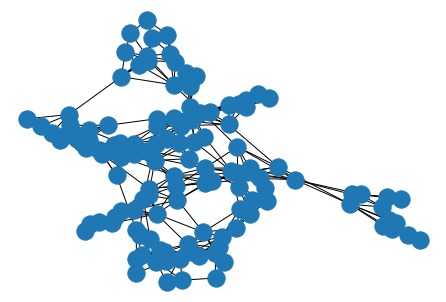

In [18]:
g = to_networkx(gp.d[10], to_undirected=True)
nx.draw(g)

In [19]:
len(gp.d)

106

In [20]:
len(gp.selection)

106

In [21]:
gp.selection[10]['PDB'].iloc[0]

'6DDE'